<a href="https://colab.research.google.com/github/Montse1708/ProyectoFinal_Dashboard/blob/main/TI_1_ProyectoFinal_JessicaMorales_CarlaSanchez.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Proyecto Final**

##Integrantes:
* **Nombre:** Jessica Montserrat Morales Enrique  
* **e-mail:** jessica.morales5556@alumnos.udg.mx

- **Nombre:** Carla Georgina Sánchez Arreguín
- **email:** carla.sanchez2472@alumnos.udg.mx

#MODULES

##Install modules

In [1065]:
pip install unidecode

In [1064]:
pip install panel

In [1066]:
import numpy as np
import pandas as pd
import math
import geopandas as gpd
import folium
import panel as pn
import panel.widgets as pnw
from unidecode import unidecode
import seaborn as sns
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact
import plotly.graph_objects as go

import plotly.express as px

#DATASET

##Dataset de COVID en México

###Dataset almacenado en link

In [1067]:
#Cargar los datos del archivo CSV
#En el siguiente link se encuentra los datos almacenados
url = 'https://raw.githubusercontent.com/marianarf/covid19_mexico_analysis/master/mexico_covid19.csv'
df = pd.read_csv(url)

###Dataset descargado de Kaggle


In [ ]:
#Cargar el dataset con los datos
#Link del repositorio en Kaggle: https://www.kaggle.com/datasets/marianarfranklin/mexico-covid19-clinical-data?resource=download
df = pd.read_csv('/content/mexico_covid19.csv')

##GeoJSON de los límites de los estados de México

In [1068]:
# Descargar el archivo GeoJSON de los límites de México
geojson_url = 'https://raw.githubusercontent.com/angelnmara/geojson/master/mexicoHigh.json'
mexico_map = gpd.read_file(geojson_url)

#MOSTRAR MAPA

In [1069]:
# Verificar y corregir geometrías inválidas
mexico_map['geometry'] = mexico_map['geometry'].apply(lambda x: x.buffer(0) if x.is_valid else x)

# Quitar acentos de los nombres de los estados
mexico_map['name'] = mexico_map['name'].apply(unidecode)

# Renombrar la columna 'ENTIDAD' a 'name' en el DataFrame df
df.rename(columns={'ENTIDAD': 'name'}, inplace=True)

# Calcular el total de casos por estado
total_casos_por_estado = df.groupby('name').size().reset_index(name='total_casos')

# Unir los datos de casos con el archivo GeoJSON
mexico_map = mexico_map.merge(total_casos_por_estado, on='name', how='left')

In [1070]:
def update_marker(selected_estado):
    # Crear un nuevo mapa para cada actualización
    m = folium.Map(location=[23.634501, -102.525593], zoom_start=5)

    for _, row in mexico_map.iterrows():
        if selected_estado == 'Todos' or selected_estado == row['name']:
            if row['geometry'].geom_type == 'Polygon' or row['geometry'].geom_type == 'MultiPolygon':
                if row['geometry'].geom_type == 'Polygon':
                    polygons = [row['geometry']]
                else:
                    polygons = row['geometry'].geoms

                for polygon in polygons:
                    coords = polygon.exterior.coords
                    # Verificar si la longitud de las coordenadas es mayor que un umbral
                    if len(coords) > 3:  # Considerar solo geometrías que representan estados individuales
                        center_lat = sum(p[1] for p in coords) / len(coords)
                        center_lon = sum(p[0] for p in coords) / len(coords)
                        folium.Marker(
                            location=[row['geometry'].centroid.y, row['geometry'].centroid.x],
                            popup=folium.Popup(f"Estado: {row['name']}<br>Total de casos: {row['total_casos']}"),
                            icon=folium.Icon(color='red', icon='info-sign')
                        ).add_to(m)
    return m

In [1071]:
selectEstado = pnw.Select(name="Estado:", width=220, value='Todos', options=['Todos'] + mexico_map['name'].tolist())

map_callback = pn.bind(update_marker, selectEstado)
map_pane = pn.pane.HTML(map_callback, width=800, height=600)

dashboard = pn.Row(map_pane)
dashboard.servable()

Row
    [0] HTML(Map, height=600, sizing_mode='fixed', width=800)

# Matriz de Correlación

In [1072]:
def create_correlation_matrix_panel(df):
    columnas_seleccionadas = ["DIABETES", "EPOC", "ASMA", "INMUSUPR", "HIPERTENSION", "OTRA_COM", "CARDIOVASCULAR", "OBESIDAD",
                               "RENAL_CRONICA", "TABAQUISMO"]

    df_filtrado = df[columnas_seleccionadas]
    matriz_correlacion = df_filtrado.corr()

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 4))  # Ajusta el tamaño de la figura aquí

    sns.heatmap(
    matriz_correlacion,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    linewidths=.5,
    annot_kws={"size": 8},
    cbar_kws={"shrink": 0.6},
    ax=ax
    )

    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right',
        fontsize=8
    )

    ax.set_yticklabels(
        ax.get_yticklabels(),
        rotation=0,
        horizontalalignment='right',
        fontsize=8
    )

    plt.tight_layout()  # Ajusta el espaciado entre subplots automáticamente

    ax.set_title("Matriz de Correlación", fontsize=8, pad=5)
    plt.close()  # Cerrar el gráfico para evitar que se muestre automáticamente

    # Convertir el gráfico en un objeto Panel
    matrix_panel = pn.pane.Matplotlib(fig)
    return matrix_panel

Matplotlib(Figure)
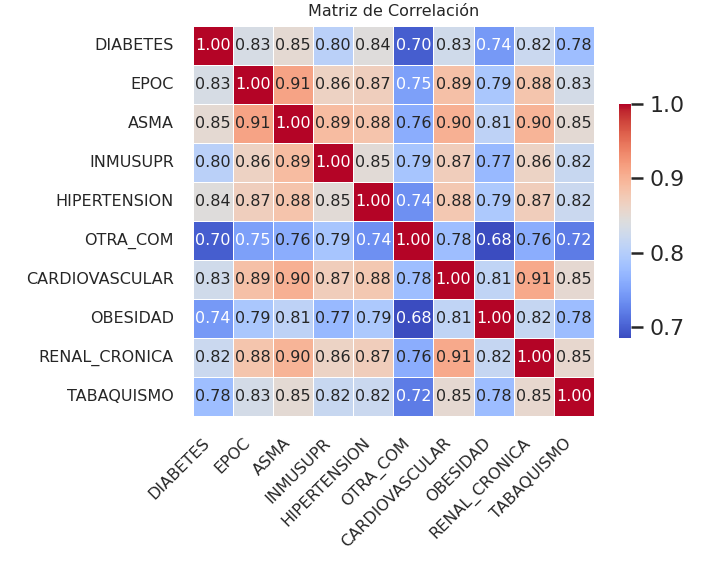

In [1073]:
panel_correlacion = create_correlation_matrix_panel(df)
panel_correlacion.servable()

#Mostrar Dashboard

Row(styles={'background': '...})
    [0] Column
        [0] Markdown(str)
        [1] Select(name='Estado:', options=['Todos', 'Zacatecas', ...], value='Todos', width=220)
        [2] Row
            [0] Select(name='Sexo:', options=['Todos', 'Femenino', ...], value='Todos', width=100)
            [1] IntInput(end=100, name='Edad:', start=1, width=100)
        [3] StaticText(value='Seleccione una métrica:')
        [4] RadioButtonGroup(name='Metrica', options=['Matriz de correlación', ...], value='Matriz de correlación', width=100)
    [1] HTML(Map, height=600, sizing_mode='fixed', width=800)
    [2] Matplotlib(Figure)
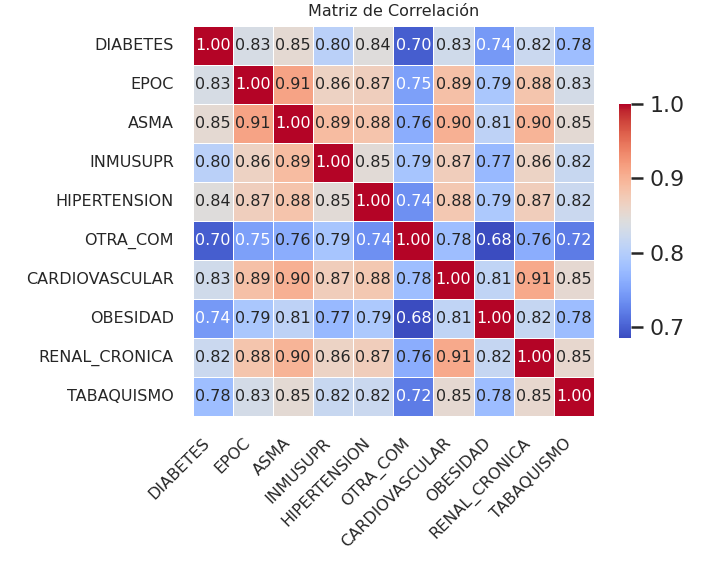

In [1074]:
# Texto en formato markdown para el panel
markdown_text = """
# DASHBOARD

### Panel params
"""
# Crear un panel con el texto markdown
panel = pn.panel(markdown_text)

# Widgets
selectEstado = pnw.Select(name="Estado:", width=220, value='Todos', options=['Todos'] + mexico_map['name'].tolist())
selectEdad = pnw.IntInput(name='Edad:', width=100, value=0, step=1, start=1, end=100)
selectSexo = pnw.Select(name='Sexo:', width=100, value='Todos', options=['Todos','Femenino', 'Masculino'])
metrica = pnw.RadioButtonGroup(name='Metrica', width=100, options=['Matriz de correlación', 'MSD'])
subtitulo = pnw.StaticText(value='Seleccione una métrica:')

# Crear la matriz de correlación
panel_correlacion = create_correlation_matrix_panel(df)

map_callback = pn.bind(update_marker, selectEstado)
map_panel = pn.pane.HTML(map_callback, width=800, height=600)

# Crear el panel con los widgets y la matriz de correlación
pn.Row(
    pn.Column(markdown_text,selectEstado, pn.Row(selectSexo, selectEdad),subtitulo, metrica),
    map_panel,
    panel_correlacion.servable(),
    styles={'background': 'lightcyan'}
)

Panel temporal, trabajando función para actualizar widget

interactive(children=(Dropdown(description='sexo', options=('Todos', 'Femenino', 'Masculino'), value='Todos'),…

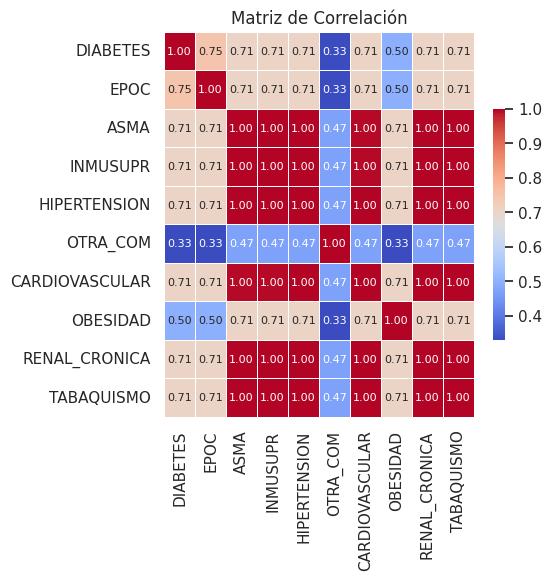

In [ ]:
import pandas as pd
import geopandas as gpd
import folium
import seaborn as sns
import matplotlib.pyplot as plt
import panel as pn
import panel.widgets as pnw
from unidecode import unidecode
from ipywidgets import interact

# Descargar el archivo GeoJSON de los límites de México
geojson_url = 'https://raw.githubusercontent.com/angelnmara/geojson/master/mexicoHigh.json'
mexico_map = gpd.read_file(geojson_url)

# Cargar los datos del archivo CSV
url = 'https://raw.githubusercontent.com/marianarf/covid19_mexico_analysis/master/mexico_covid19.csv'
df = pd.read_csv(url)

# Función para crear el mapa de COVID-19
def create_covid_map(df, mexico_map):
    # Quitar acentos
    mexico_map['name'] = mexico_map['name'].apply(unidecode)

    # Calcular el total de casos por estado
    total_casos_por_estado = df.groupby('ENTIDAD').size().reset_index(name='total_casos')

    # Unir los datos de casos con el archivo GeoJSON
    mexico_map = mexico_map.merge(total_casos_por_estado, left_on='name', right_on='ENTIDAD', how='left')

    # Crear un mapa de folium
    m = folium.Map(location=[24, -102], zoom_start=5, tiles='cartodbpositron')

    # Añadir el mapa de coropletas (choropleth map)
    folium.Choropleth(
        geo_data=mexico_map,
        name='Total de Casos de COVID-19 por Estado',
        data=mexico_map,
        columns=['name', 'total_casos'],
        key_on='feature.properties.name',
        fill_color='YlOrRd',
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name='Total de Casos de COVID-19 por Estado'
    ).add_to(m)

    # Convertir el mapa en un objeto Panel
    map_panel = pn.pane.HTML(m._repr_html_(), sizing_mode='stretch_both')
    return map_panel
# Función para crear la matriz de correlación
def create_correlation_matrix_panel2(df, sexo, edad):
    # Filtrar el DataFrame según la selección de sexo y edad
    if sexo != 'Todos' and edad != 0:
        df_filtrado = df[(df['SEXO'] == sexo) & (df['EDAD'] == edad)]
    elif sexo != 'Todos':
        df_filtrado = df[df['SEXO'] == sexo]
    elif edad != 0:
        df_filtrado = df[df['EDAD'] == edad]
    else:
        df_filtrado = df

    columnas_seleccionadas = ["DIABETES", "EPOC", "ASMA", "INMUSUPR", "HIPERTENSION", "OTRA_COM", "CARDIOVASCULAR", "OBESIDAD",
                               "RENAL_CRONICA", "TABAQUISMO"]

    df_filtrado = df_filtrado[columnas_seleccionadas]
    matriz_correlacion = df_filtrado.corr()

    sns.set(style="white")
    plt.figure(figsize=(5, 5))
    sns.heatmap(matriz_correlacion, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5, annot_kws={"size": 8}, cbar_kws={"shrink": 0.6})
    plt.title("Matriz de Correlación")

    # Convertir la figura en un objeto Panel
    matrix_panel = pn.pane.Matplotlib(plt.gcf(), tight=True, sizing_mode='stretch_both')
    return matrix_panel

# Widgets
selectEstado = pnw.Select(name="Estado:", width=220, value='Todos', options=['Todos','Jalisco'])
selectEdad = pnw.Select(name='Edad:', width=100, value=0,options=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,30,40,50,60,70])
selectSexo = pnw.Select(name='Sexo:', width=100, value='Todos', options=['Todos','Femenino', 'Masculino'])

# Función para actualizar la matriz de correlación y el mapa de COVID-19
@interact(sexo=selectSexo.options, edad=selectEdad.options)
def update_plots(sexo, edad):
    # Crear el panel con los widgets y los paneles de los mapas
    layout = pn.Row(
        pn.Column(selectEstado, pn.Row(selectSexo, selectEdad)),
        create_covid_map(df, mexico_map),
        create_correlation_matrix_panel2(df, sexo, edad)
    )
    layout.servable()